# Quantization Layer Demo
This IPython Notebook provides the demonstration of newly-built quantization layer in Caffe, which can emulate the quantization procedure in neural network.

## Setup
Basic setup for caffe module import.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../../'  # points to the root directory of caffe
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

# import python version of fixed_point
from fixed_point import *

- Define a helper function to generate the simple prototxt file

In [2]:
from caffe import layers as L, params as P

def simple_quantization_net(filename, bit_width, data_range, round_method='FLOOR',
                           round_strategy='CONSERVATIVE'):
    '''Generate a simple quantization network consisting only 
       one quantization layer'''
    n = caffe.NetSpec()
    n.data = L.DummyData(shape=dict(dim=[10, 3, 100, 100])) # arbitrary 4D blob
    
    quantization_param = dict(bit_width=bit_width, range=data_range)
    # generate the corresponding quantization parameters: round_method
    if round_method.upper() == 'FLOOR':
        quantization_param['round_method'] = P.Quantization.FLOOR
    elif round_method.upper() == 'CEIL':
        quantization_param['round_method'] = P.Quantization.CEIL
    elif round_method.upper() == 'ROUND':
        quantization_param['round_method'] = P.Quantization.ROUND
    elif round_method.upper() == 'TRUNC':
        quantization_param['round_method'] = P.Quantization.TRUNC
    else:
        raise TypeError('undefined round method: %s' % (round_method,))
    
    # generate the corresponding quantization parameters: round_strategy
    if round_strategy.upper() == 'CONSERVATIVE':
        quantization_param['round_strategy'] = P.Quantization.CONSERVATIVE
    elif round_strategy.upper() == 'NEUTRAL':
        quantization_param['round_strategy'] = P.Quantization.NEUTRAL
    elif round_strategy.upper() == 'AGGRESSIVE':
        quantization_param['round_strategy'] = P.Quantization.AGGRESSIVE
    else:
        raise TypeError('undefined round strategy: %s' % (round_strategy,))
    
    # generate the layer 
    n.data_quant = L.Quantization(n.data, quantization_param=quantization_param)
    
    with open(filename, 'w') as f:
        f.write(str(n.to_proto()))

## Test the Python FixedPoint implementation and the Caffe quantization layer
- Case 1: [-2700, +2700] data 

Generated prototxt
layer {
  name: "data"
  type: "DummyData"
  top: "data"
  dummy_data_param {
    shape {
      dim: 10
      dim: 3
      dim: 100
      dim: 100
    }
  }
}
layer {
  name: "data_quant"
  type: "Quantization"
  bottom: "data"
  top: "data_quant"
  quantization_param {
    round_method: ROUND
    round_strategy: AGGRESSIVE
    bit_width: 5
    range: -2700.0
    range: 2700.0
  }
}
Diff: 0
no. unique values: 32


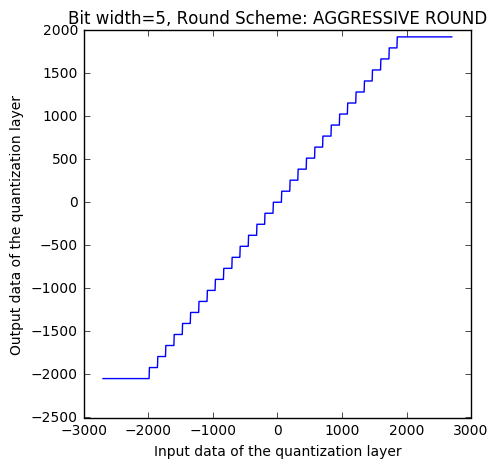

In [3]:
## test input data ranging [-2700, 2700] using 5-bit
# basic settings
simple_quantization_model = './quantization.prototxt'
input_data = np.linspace(-2700, 2700, num=1000);
N = 5
round_method = 'ROUND'
round_strategy = 'AGGRESSIVE'

## python fixed point
PyFixedPoint = FixedPoint(input_range=[input_data.min(), input_data.max()], N=N, 
                          round_method=round_method, round_strategy=round_strategy)
py_quantized_data = PyFixedPoint.quantize(input_data)

## Caffe quantization network
simple_quantization_net(simple_quantization_model, bit_width=N, 
                        data_range=[input_data.min(), input_data.max()], 
                        round_method=round_method, round_strategy=round_strategy)

print 'Generated prototxt'
!cat $simple_quantization_model

# Load the simple quantization network 
net = caffe.Net(simple_quantization_model, caffe.TEST)

# do the feedforward
net.blobs['data'].reshape(*input_data.shape)
net.blobs['data'].data[...] = input_data

net.forward()

## Check equivalence 
print 'Diff: %d' % (np.sum(net.blobs['data_quant'].data != py_quantized_data))

plt.figure(figsize=(5, 5))
plt.plot(input_data, py_quantized_data)
plt.xlabel('Input data of the quantization layer')
plt.ylabel('Output data of the quantization layer')
plt.title('Bit width=%d, Round Scheme: %s %s' % (N, round_strategy, round_method))
print 'no. unique values: %d' % (len(np.unique(py_quantized_data)))

- Case 2: [-0.0012, +0.0012] data 

Generated prototxt
layer {
  name: "data"
  type: "DummyData"
  top: "data"
  dummy_data_param {
    shape {
      dim: 10
      dim: 3
      dim: 100
      dim: 100
    }
  }
}
layer {
  name: "data_quant"
  type: "Quantization"
  bottom: "data"
  top: "data_quant"
  quantization_param {
    round_method: FLOOR
    round_strategy: NEUTRAL
    bit_width: 5
    range: -0.0012
    range: 0.0012
  }
}
Diff: 0
no. unique values: 32


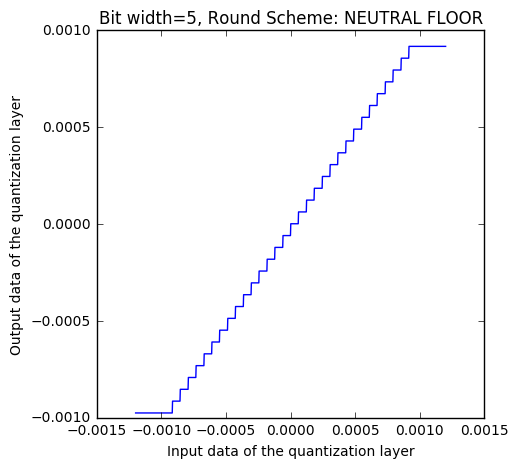

In [4]:
## test input data ranging [-0.0012, +0.0012] using 5-bit
# basic settings
simple_quantization_model = './quantization.prototxt'
input_data = np.linspace(-0.0012, 0.0012, num=1000);
N = 5
round_method = 'FLOOR'
round_strategy = 'NEUTRAL'

## python fixed point
PyFixedPoint = FixedPoint(input_range=[input_data.min(), input_data.max()], N=N, 
                          round_method=round_method, round_strategy=round_strategy)
py_quantized_data = PyFixedPoint.quantize(input_data)

## Caffe quantization network
simple_quantization_net(simple_quantization_model, bit_width=N, 
                        data_range=[input_data.min(), input_data.max()], 
                        round_method=round_method, round_strategy=round_strategy)

print 'Generated prototxt'
!cat $simple_quantization_model

# Load the simple quantization network 
net = caffe.Net(simple_quantization_model, caffe.TEST)

# do the feedforward
net.blobs['data'].reshape(*input_data.shape)
net.blobs['data'].data[...] = input_data

net.forward()

## Check equivalence 
print 'Diff: %d' % (np.sum(net.blobs['data_quant'].data != py_quantized_data))

plt.figure(figsize=(5, 5))
plt.plot(input_data, py_quantized_data)
plt.xlabel('Input data of the quantization layer')
plt.ylabel('Output data of the quantization layer')
plt.title('Bit width=%d, Round Scheme: %s %s' % (N, round_strategy, round_method))
print 'no. unique values: %d' % (len(np.unique(py_quantized_data)))

- Case 3: [0, 0.0078] data 

Generated prototxt
layer {
  name: "data"
  type: "DummyData"
  top: "data"
  dummy_data_param {
    shape {
      dim: 10
      dim: 3
      dim: 100
      dim: 100
    }
  }
}
layer {
  name: "data_quant"
  type: "Quantization"
  bottom: "data"
  top: "data_quant"
  quantization_param {
    round_method: FLOOR
    round_strategy: CONSERVATIVE
    bit_width: 5
    range: 0.0
    range: 0.0078
  }
}
Diff: 0
no. unique values: 16


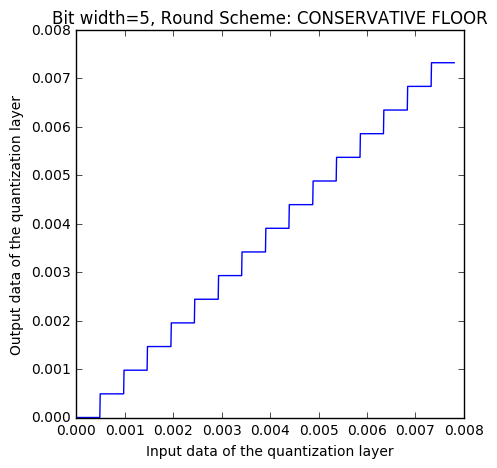

In [5]:
## test input data ranging [0, +0.0078] using 5-bit
# basic settings
simple_quantization_model = './quantization.prototxt'
input_data = np.linspace(0, 0.0078, num=1000);
N = 5
round_method = 'FLOOR'
round_strategy = 'CONSERVATIVE'

## python fixed point
PyFixedPoint = FixedPoint(input_range=[input_data.min(), input_data.max()], N=N, 
                          round_method=round_method, round_strategy=round_strategy)
py_quantized_data = PyFixedPoint.quantize(input_data)

## Caffe quantization network
simple_quantization_net(simple_quantization_model, bit_width=N, 
                        data_range=[input_data.min(), input_data.max()], 
                        round_method=round_method, round_strategy=round_strategy)

print 'Generated prototxt'
!cat $simple_quantization_model

# Load the simple quantization network 
net = caffe.Net(simple_quantization_model, caffe.TEST)

# do the feedforward
net.blobs['data'].reshape(*input_data.shape)
net.blobs['data'].data[...] = input_data

net.forward()

## Check equivalence 
print 'Diff: %d' % (np.sum(net.blobs['data_quant'].data != py_quantized_data))

plt.figure(figsize=(5, 5))
plt.plot(input_data, py_quantized_data)
plt.xlabel('Input data of the quantization layer')
plt.ylabel('Output data of the quantization layer')
plt.title('Bit width=%d, Round Scheme: %s %s' % (N, round_strategy, round_method))
print 'no. unique values: %d' % (len(np.unique(py_quantized_data)))

- Case 3: integer data can be fully represented

Generated prototxt
layer {
  name: "data"
  type: "DummyData"
  top: "data"
  dummy_data_param {
    shape {
      dim: 10
      dim: 3
      dim: 100
      dim: 100
    }
  }
}
layer {
  name: "data_quant"
  type: "Quantization"
  bottom: "data"
  top: "data_quant"
  quantization_param {
    round_method: FLOOR
    round_strategy: NEUTRAL
    bit_width: 5
    range: -16
    range: 15
  }
}
Diff: 0
no. unique values: 32


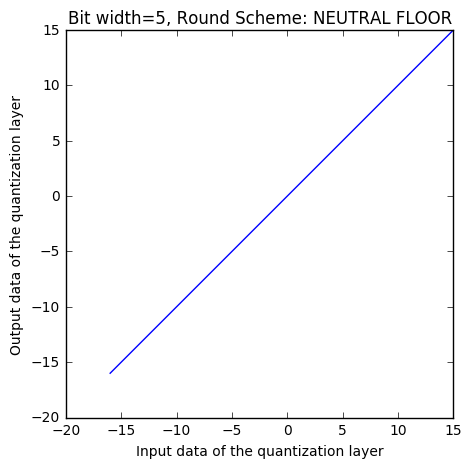

In [6]:
## test input data ranging [-16, -15, ..., 15] using 5-bit
# basic settings
simple_quantization_model = './quantization.prototxt'
input_data = np.arange(-16, 16);
N = 5
round_method = 'FLOOR'
round_strategy = 'NEUTRAL'

## python fixed point
PyFixedPoint = FixedPoint(input_range=[input_data.min(), input_data.max()], N=N, 
                          round_method=round_method, round_strategy=round_strategy)
py_quantized_data = PyFixedPoint.quantize(input_data)

## Caffe quantization network
simple_quantization_net(simple_quantization_model, bit_width=N, 
                        data_range=[input_data.min(), input_data.max()], 
                        round_method=round_method, round_strategy=round_strategy)

print 'Generated prototxt'
!cat $simple_quantization_model

# Load the simple quantization network 
net = caffe.Net(simple_quantization_model, caffe.TEST)

# do the feedforward
net.blobs['data'].reshape(*input_data.shape)
net.blobs['data'].data[...] = input_data

net.forward()

## Check equivalence 
print 'Diff: %d' % (np.sum(net.blobs['data_quant'].data != py_quantized_data))

plt.figure(figsize=(5, 5))
plt.plot(input_data, py_quantized_data)
plt.xlabel('Input data of the quantization layer')
plt.ylabel('Output data of the quantization layer')
plt.title('Bit width=%d, Round Scheme: %s %s' % (N, round_strategy, round_method))
print 'no. unique values: %d' % (len(np.unique(py_quantized_data)))

- Case 4: non-positive number 

Generated prototxt
layer {
  name: "data"
  type: "DummyData"
  top: "data"
  dummy_data_param {
    shape {
      dim: 10
      dim: 3
      dim: 100
      dim: 100
    }
  }
}
layer {
  name: "data_quant"
  type: "Quantization"
  bottom: "data"
  top: "data_quant"
  quantization_param {
    round_method: FLOOR
    round_strategy: NEUTRAL
    bit_width: 5
    range: -5800.0
    range: -100.0
  }
}
Diff: 0
no. unique values: 23


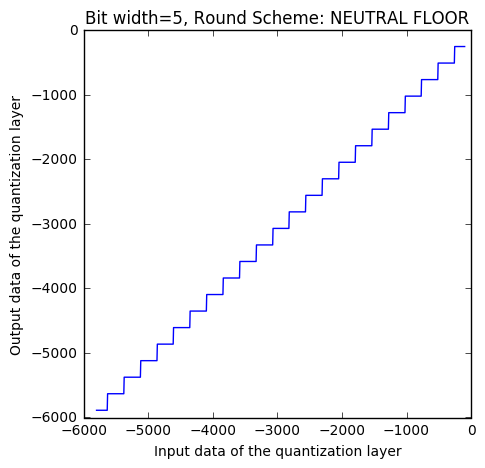

In [7]:
## test input data ranging [-16, -15, ..., 15] using 5-bit
# basic settings
simple_quantization_model = './quantization.prototxt'
input_data = np.linspace(-5800, -100, num=1000);
N = 5
round_method = 'FLOOR'
round_strategy = 'NEUTRAL'

## python fixed point
PyFixedPoint = FixedPoint(input_range=[input_data.min(), input_data.max()], N=N, 
                          round_method=round_method, round_strategy=round_strategy)
py_quantized_data = PyFixedPoint.quantize(input_data)

## Caffe quantization network
simple_quantization_net(simple_quantization_model, bit_width=N, 
                        data_range=[input_data.min(), input_data.max()], 
                        round_method=round_method, round_strategy=round_strategy)

print 'Generated prototxt'
!cat $simple_quantization_model

# Load the simple quantization network 
net = caffe.Net(simple_quantization_model, caffe.TEST)

# do the feedforward
net.blobs['data'].reshape(*input_data.shape)
net.blobs['data'].data[...] = input_data

net.forward()

## Check equivalence 
print 'Diff: %d' % (np.sum(net.blobs['data_quant'].data != py_quantized_data))

plt.figure(figsize=(5, 5))
plt.plot(input_data, py_quantized_data)
plt.xlabel('Input data of the quantization layer')
plt.ylabel('Output data of the quantization layer')
plt.title('Bit width=%d, Round Scheme: %s %s' % (N, round_strategy, round_method))
print 'no. unique values: %d' % (len(np.unique(py_quantized_data)))